In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root_dir = '/content/drive/My Drive/'
base_dir = '/content/drive/My Drive/fastai-v3'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Recognize Indian Currency by using Transfer Learning

In [0]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import PIL
from matplotlib.pyplot import imshow

     |████████████████████████████████| 388.9MB 92kB/s 
     |████████████████████████████████| 460kB 45.8MB/s 
     |████████████████████████████████| 3.8MB 30.5MB/s 


In [0]:
os.listdir(base_dir)

['Glasses-NoGlasses',
 'kaggle.json',
 'Currency-Dataset',
 'Indian-Currency-Dataset']

## Setup Input Pipeline

In [0]:
path_data = base_dir + '/Indian-Currency-Dataset/train'
path_test = base_dir + '/Indian-Currency-Dataset/test'
path_aug = base_dir + '/Indian-Currency-Dataset/train/augmented_images'

os.listdir(path_data)

['models',
 '500',
 '50',
 '100',
 '20',
 '10',
 '2000',
 '200',
 'none',
 '5',
 'export(19 8).pkl',
 'save',
 'labels.txt']

In [0]:
# ?tf.keras.preprocessing.image.ImageDataGenerator.flow_from_directory

In [0]:
IMAGE_SIZE = 600
BATCH_SIZE = 16

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    brightness_range=[1.2, 1.0],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.6,
    fill_mode = 'reflect',
    vertical_flip = True,
    validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    path_data,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    seed = 10,
    # save_to_dir = path_aug,
    # save_prefix = 'tr-0',
    # save_format = 'jpg',
    batch_size=BATCH_SIZE, 
    subset='training')

# datagen.fit(train_generator.next()[0])

val_generator = datagen.flow_from_directory(
    path_data,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed = 3,
    subset='validation')

test_generator = test_datagen.flow_from_directory(path_test,
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size=BATCH_SIZE)

Found 4258 images belonging to 9 classes.
Found 1059 images belonging to 9 classes.
Found 294 images belonging to 9 classes.


In [0]:
for image_batch, label_batch in train_generator:
  break

In [0]:
for i in range(64):
  plt.figure()
  imshow(image_batch[i])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
 IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights= 'imagenet')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


W0904 15:32:43.645490 140445039916928 nn_ops.py:4283] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
base_model.trainable = False

In [0]:
# model.load_weights(path_data + '/save/fine_tuning/save-weights-1-top.h5')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 19, 19, 1280)      2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 32)        368672    
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 17, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 32)        128       
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                1

In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 10


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/5


W0904 15:33:04.625407 140445039916928 nn_ops.py:4283] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


  1/267 [..............................] - ETA: 55:59 - loss: 3.0206 - categorical_accuracy: 0.0625

W0904 15:33:06.998694 140445039916928 nn_ops.py:4283] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


  2/267 [..............................] - ETA: 32:19 - loss: 2.8834 - categorical_accuracy: 0.0625

W0904 15:33:11.573670 140445039916928 nn_ops.py:4283] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


  3/267 [..............................] - ETA: 28:14 - loss: 3.0091 - categorical_accuracy: 0.1042

W0904 15:33:16.173912 140445039916928 nn_ops.py:4283] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


267/267 [==============================] - 2131s 8s/step - loss: 1.3364 - categorical_accuracy: 0.5557 - val_loss: 2.3065 - val_categorical_accuracy: 0.2672
Epoch 2/5
267/267 [==============================] - 491s 2s/step - loss: 0.8510 - categorical_accuracy: 0.7191 - val_loss: 2.7150 - val_categorical_accuracy: 0.2720
Epoch 3/5
267/267 [==============================] - 507s 2s/step - loss: 0.7324 - categorical_accuracy: 0.7590 - val_loss: 3.0171 - val_categorical_accuracy: 0.3239
Epoch 4/5
267/267 [==============================] - 498s 2s/step - loss: 0.6439 - categorical_accuracy: 0.7870 - val_loss: 2.5836 - val_categorical_accuracy: 0.3267
Epoch 5/5
267/267 [==============================] - 460s 2s/step - loss: 0.6283 - categorical_accuracy: 0.7966 - val_loss: 3.2123 - val_categorical_accuracy: 0.2833


In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-1-top.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
65/65 [==============================] - 101s 2s/step - loss: 0.1533 - categorical_accuracy: 0.9449 - val_loss: 1.3916 - val_categorical_accuracy: 0.6887
Epoch 2/5
65/65 [==============================] - 90s 1s/step - loss: 0.1218 - categorical_accuracy: 0.9565 - val_loss: 1.1943 - val_categorical_accuracy: 0.7198
Epoch 3/5
65/65 [==============================] - 91s 1s/step - loss: 0.0876 - categorical_accuracy: 0.9729 - val_loss: 2.8907 - val_categorical_accuracy: 0.5409
Epoch 4/5
65/65 [==============================] - 90s 1s/step - loss: 0.0968 - categorical_accuracy: 0.9720 - val_loss: 2.4122 - val_categorical_accuracy: 0.7237
Epoch 5/5
65/65 [==============================] - 92s 1s/step - loss: 0.0393 - categorical_accuracy: 0.9874 - val_loss: 1.2261 - val_categorical_accuracy: 0.7665


In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2-top.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
epochs = 40

history_1 = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/40
30/32 [===========================>..] - ETA: 2s - loss: 0.5543 - accuracy: 0.8525

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 58s 2s/step - loss: 0.5545 - accuracy: 0.8519 - val_loss: 4.2724 - val_accuracy: 0.3008
Epoch 2/40
32/32 [==============================] - 49s 2s/step - loss: 0.5564 - accuracy: 0.8428 - val_loss: 4.7080 - val_accuracy: 0.3171
Epoch 3/40
32/32 [==============================] - 49s 2s/step - loss: 0.4311 - accuracy: 0.8655 - val_loss: 5.3580 - val_accuracy: 0.2947
Epoch 4/40
32/32 [==============================] - 49s 2s/step - loss: 0.4088 - accuracy: 0.8705 - val_loss: 4.1000 - val_accuracy: 0.3516
Epoch 5/40
32/32 [==============================] - 49s 2s/step - loss: 0.3656 - accuracy: 0.8927 - val_loss: 5.6942 - val_accuracy: 0.3130
Epoch 6/40
32/32 [==============================] - 48s 2s/step - loss: 0.4129 - accuracy: 0.8670 - val_loss: 5.0287 - val_accuracy: 0.3130
Epoch 7/40
32/32 [==============================] - 48s 1s/step - loss: 0.3456 - accuracy: 0.8877 - val_loss: 4.8635 - val_accuracy: 0.3354
Epoch 8/40
32/32 [=============

In [0]:
model.save(path_data + '/save/fine_tuning/stage-2.h5')

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2.h5')

## Fine tuning

### Un-freeze the top layers of the model


In [0]:
# model.layers[0].trainable = True
# base_model.trainable = False
# model.load_weights(path_data + '/save/fine_tuning/saved-weights-10.h5')

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 14, 14, 2048)      23587712  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        589856    
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)               

In [0]:
model.load_weights(path_data + '/save/fine_tuning/save-weights-2-from2-Res50.h5')

In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 166


### Continue Train the model

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
65/65 [==============================] - 101s 2s/step - loss: 0.3481 - categorical_accuracy: 0.8849 - val_loss: 2.5402 - val_categorical_accuracy: 0.7160
Epoch 2/5
65/65 [==============================] - 89s 1s/step - loss: 0.1960 - categorical_accuracy: 0.9410 - val_loss: 3.1519 - val_categorical_accuracy: 0.6070
Epoch 3/5
65/65 [==============================] - 90s 1s/step - loss: 0.1419 - categorical_accuracy: 0.9507 - val_loss: 1.2410 - val_categorical_accuracy: 0.7665
Epoch 4/5
65/65 [==============================] - 90s 1s/step - loss: 0.0964 - categorical_accuracy: 0.9613 - val_loss: 2.0333 - val_categorical_accuracy: 0.7004
Epoch 5/5
65/65 [==============================] - 90s 1s/step - loss: 0.1280 - categorical_accuracy: 0.9632 - val_loss: 1.2242 - val_categorical_accuracy: 0.7160


In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-1-from3-Res50.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 50,
                         validation_data=val_generator)

Epoch 1/50
267/267 [==============================] - 293s 1s/step - loss: 0.5712 - categorical_accuracy: 0.8260 - val_loss: 3.1179 - val_categorical_accuracy: 0.2455
Epoch 2/50
267/267 [==============================] - 292s 1s/step - loss: 0.5276 - categorical_accuracy: 0.8377 - val_loss: 2.3594 - val_categorical_accuracy: 0.3437
Epoch 3/50
267/267 [==============================] - 294s 1s/step - loss: 0.3984 - categorical_accuracy: 0.8736 - val_loss: 1.9689 - val_categorical_accuracy: 0.4230
Epoch 4/50
267/267 [==============================] - 293s 1s/step - loss: 0.4299 - categorical_accuracy: 0.8692 - val_loss: 1.3965 - val_categorical_accuracy: 0.5911
Epoch 5/50
267/267 [==============================] - 293s 1s/step - loss: 0.3574 - categorical_accuracy: 0.8913 - val_loss: 2.6732 - val_categorical_accuracy: 0.4731
Epoch 6/50
267/267 [==============================] - 292s 1s/step - loss: 0.3782 - categorical_accuracy: 0.8870 - val_loss: 1.3346 - val_categorical_accuracy: 0.607

In [0]:
 model.save_weights(path_data + '/save/fine_tuning/save-weights-2-from2-Res50.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
267/267 [==============================] - 294s 1s/step - loss: 0.1111 - categorical_accuracy: 0.9667 - val_loss: 1.3547 - val_categorical_accuracy: 0.6601
Epoch 2/5
267/267 [==============================] - 292s 1s/step - loss: 0.1020 - categorical_accuracy: 0.9678 - val_loss: 2.7466 - val_categorical_accuracy: 0.4297
Epoch 3/5
267/267 [==============================] - 292s 1s/step - loss: 0.0870 - categorical_accuracy: 0.9739 - val_loss: 1.4468 - val_categorical_accuracy: 0.6780
Epoch 4/5
267/267 [==============================] - 291s 1s/step - loss: 0.1040 - categorical_accuracy: 0.9685 - val_loss: 2.8196 - val_categorical_accuracy: 0.4466
Epoch 5/5
267/267 [==============================] - 292s 1s/step - loss: 0.0986 - categorical_accuracy: 0.9704 - val_loss: 1.4911 - val_categorical_accuracy: 0.7186


In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
267/267 [==============================] - 293s 1s/step - loss: 0.0831 - categorical_accuracy: 0.9760 - val_loss: 1.5658 - val_categorical_accuracy: 0.6771
Epoch 2/5
267/267 [==============================] - 293s 1s/step - loss: 0.0855 - categorical_accuracy: 0.9753 - val_loss: 3.3517 - val_categorical_accuracy: 0.3248
Epoch 3/5
267/267 [==============================] - 294s 1s/step - loss: 0.1009 - categorical_accuracy: 0.9678 - val_loss: 1.3860 - val_categorical_accuracy: 0.6704
Epoch 4/5
267/267 [==============================] - 295s 1s/step - loss: 0.0854 - categorical_accuracy: 0.9760 - val_loss: 3.3982 - val_categorical_accuracy: 0.4759
Epoch 5/5
267/267 [==============================] - 295s 1s/step - loss: 0.0902 - categorical_accuracy: 0.9709 - val_loss: 1.5812 - val_categorical_accuracy: 0.6025


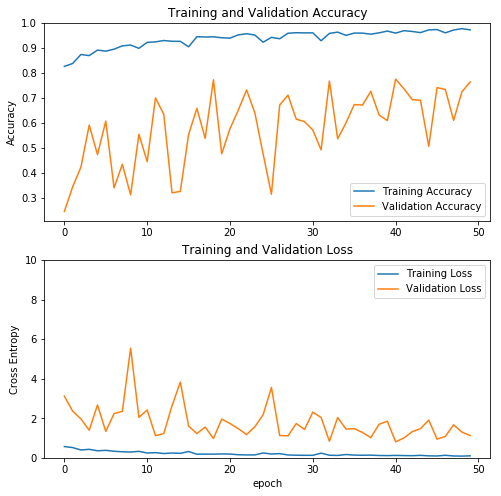

In [0]:
acc = history_fine.history['categorical_accuracy']
val_acc = history_fine.history['val_categorical_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 10,
                         validation_data=val_generator)

Epoch 1/10
262/262 [==============================] - 551s 2s/step - loss: 0.0718 - categorical_accuracy: 0.9763 - val_loss: 3.2012 - val_categorical_accuracy: 0.6750
Epoch 2/10
262/262 [==============================] - 533s 2s/step - loss: 0.0962 - categorical_accuracy: 0.9723 - val_loss: 2.0268 - val_categorical_accuracy: 0.6788
Epoch 3/10
262/262 [==============================] - 525s 2s/step - loss: 0.0721 - categorical_accuracy: 0.9782 - val_loss: 3.0902 - val_categorical_accuracy: 0.6308
Epoch 4/10
262/262 [==============================] - 514s 2s/step - loss: 0.0666 - categorical_accuracy: 0.9792 - val_loss: 2.0423 - val_categorical_accuracy: 0.7202
Epoch 5/10
262/262 [==============================] - 536s 2s/step - loss: 0.0650 - categorical_accuracy: 0.9813 - val_loss: 1.1903 - val_categorical_accuracy: 0.7933
Epoch 6/10
262/262 [==============================] - 509s 2s/step - loss: 0.0813 - categorical_accuracy: 0.9739 - val_loss: 2.3755 - val_categorical_accuracy: 0.697

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2-from2.h5')

#Validation Testing

In [0]:
y_pred = model.predict_generator(val_generator)

In [0]:
labels = val_generator.classes
filenames = val_generator.filenames

In [0]:
probs = y_pred[:, 0]

(1040, 9)

#Testing

In [0]:
model.evaluate(test_generator)

In [0]:
train_generator.shuffle = False

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.BrBG):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

###On Train

In [0]:
Y_pred = model.predict_generator(train_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
print(confusion_matrix(train_generator.classes[train_generator.index_array], y_pred))
print(classification_report(train_generator.classes[train_generator.index_array], y_pred))

267/267 [==============================] - 374s 1s/step
[[505   1   0   2  14   0   0   0   1]
 [  8 501   0   0   2   0   0   0   0]
 [ 17   6 455  14  25   0   2   1   0]
 [  9   0   0 482   0   0   0   0   0]
 [ 21   5   0   1 481   1   0   0   0]
 [  6   6   0   0   8 507   0   0   3]
 [  8   1  16   1   7   0 489   0   0]
 [  5  41   0   0   5   0   0 513   0]
 [  0   0   0   0   0   0   0   0  88]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       523
           1       0.89      0.98      0.93       511
           2       0.97      0.88      0.92       520
           3       0.96      0.98      0.97       491
           4       0.89      0.94      0.92       509
           5       1.00      0.96      0.98       530
           6       1.00      0.94      0.97       522
           7       1.00      0.91      0.95       564
           8       0.96      1.00      0.98        88

    accuracy                           0.94      4

In [0]:
from sklearn.utils.multiclass import unique_labels

Confusion matrix, without normalization
[[505   1   0   2  14   0   0   0   1]
 [  8 501   0   0   2   0   0   0   0]
 [ 17   6 455  14  25   0   2   1   0]
 [  9   0   0 482   0   0   0   0   0]
 [ 21   5   0   1 481   1   0   0   0]
 [  6   6   0   0   8 507   0   0   3]
 [  8   1  16   1   7   0 489   0   0]
 [  5  41   0   0   5   0   0 513   0]
 [  0   0   0   0   0   0   0   0  88]]


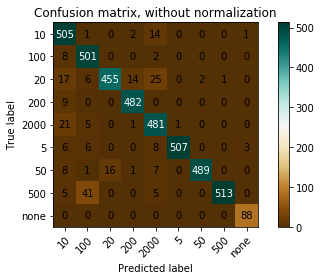

In [0]:
plot_confusion_matrix(train_generator.classes[train_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)

Confusion matrix, without normalization
[[505   1   0   2  14   0   0   0   1]
 [  8 501   0   0   2   0   0   0   0]
 [ 17   6 455  14  25   0   2   1   0]
 [  9   0   0 482   0   0   0   0   0]
 [ 21   5   0   1 481   1   0   0   0]
 [  6   6   0   0   8 507   0   0   3]
 [  8   1  16   1   7   0 489   0   0]
 [  5  41   0   0   5   0   0 513   0]
 [  0   0   0   0   0   0   0   0  88]]


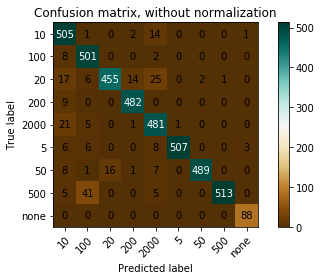

In [0]:
plot_confusion_matrix(train_generator.classes, y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)

###On Validation

In [0]:
val_generator.shuffle = False

67/67 [==============================] - 67s 1s/step
Confusion matrix, without normalization
[[120   2   0   1   7   0   0   0   0]
 [  5 121   0   0   1   0   0   0   0]
 [  9   0 101   6  11   0   1   0   1]
 [ 20   1   0  87  13   0   0   1   0]
 [ 12  13   3   0  98   1   0   0   0]
 [  4  14   1   0  47  66   0   0   0]
 [ 15   5   6   0   9   1  92   0   2]
 [ 23   8   0   0  13   2   1  93   0]
 [  0   0   0   0   0   0   0   0  22]]
              precision    recall  f1-score   support

           0       0.58      0.92      0.71       130
           1       0.74      0.95      0.83       127
           2       0.91      0.78      0.84       129
           3       0.93      0.71      0.81       122
           4       0.49      0.77      0.60       127
           5       0.94      0.50      0.65       132
           6       0.98      0.71      0.82       130
           7       0.99      0.66      0.79       140
           8       0.88      1.00      0.94        22

    accuracy 

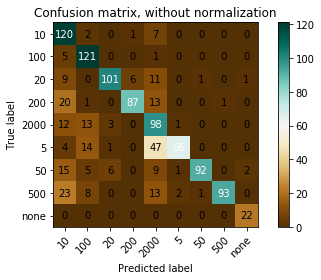

In [0]:
Y_pred = model.predict_generator(val_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
plot_confusion_matrix(val_generator.classes[val_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)
print(classification_report(val_generator.classes[val_generator.index_array], y_pred))

In [0]:
val_generator.shuffle = True

In [0]:
Y_pred = model.predict_generator(val_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
y_pred

67/67 [==============================] - 67s 1s/step


array([0, 8, 3, ..., 8, 8, 8])

In [0]:
val_generator.index_array

array([   0,    1,    2, ..., 1056, 1057, 1058])

In [0]:
val_generator.classes

array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

In [0]:
val_generator.classes[val_generator.index_array]

array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

Confusion matrix, without normalization
[[114   3   0   4   8   0   0   0   1]
 [  8 119   0   0   0   0   0   0   0]
 [  6   1 103   5  12   0   1   0   1]
 [ 16   1   0  93  10   1   0   1   0]
 [ 12  14   4   0  93   3   0   1   0]
 [  4   7   2   1  59  58   0   0   1]
 [ 17   7   3   1   6   0  96   0   0]
 [ 19   7   2   0   7   0   2 103   0]
 [  1   0   0   0   0   0   0   0  21]]
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       130
           1       0.75      0.94      0.83       127
           2       0.90      0.80      0.85       129
           3       0.89      0.76      0.82       122
           4       0.48      0.73      0.58       127
           5       0.94      0.44      0.60       132
           6       0.97      0.74      0.84       130
           7       0.98      0.74      0.84       140
           8       0.88      0.95      0.91        22

    accuracy                           0.76      1059
   macro avg

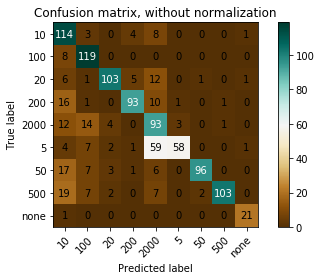

In [0]:
plot_confusion_matrix(val_generator.classes, y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)
print(classification_report(val_generator.classes, y_pred))

Confusion matrix, without normalization
[[114   3   0   4   8   0   0   0   1]
 [  8 119   0   0   0   0   0   0   0]
 [  6   1 103   5  12   0   1   0   1]
 [ 16   1   0  93  10   1   0   1   0]
 [ 12  14   4   0  93   3   0   1   0]
 [  4   7   2   1  59  58   0   0   1]
 [ 17   7   3   1   6   0  96   0   0]
 [ 19   7   2   0   7   0   2 103   0]
 [  1   0   0   0   0   0   0   0  21]]
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       130
           1       0.75      0.94      0.83       127
           2       0.90      0.80      0.85       129
           3       0.89      0.76      0.82       122
           4       0.48      0.73      0.58       127
           5       0.94      0.44      0.60       132
           6       0.97      0.74      0.84       130
           7       0.98      0.74      0.84       140
           8       0.88      0.95      0.91        22

    accuracy                           0.76      1059
   macro avg

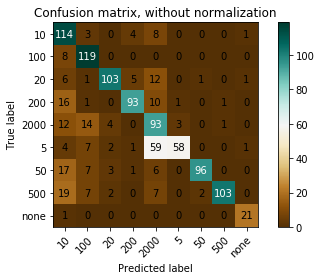

In [0]:
plot_confusion_matrix(val_generator.classes[val_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)
print(classification_report(val_generator.classes[val_generator.index_array], y_pred))

###On Test

In [0]:
test_generator.shuffle = True

In [0]:
Y_pred = model.predict_generator(test_generator)
Y_pred.shape

(294, 9)

In [0]:
y_pred = np.argmax(Y_pred, axis = 1)
y_pred

array([5, 8, 0, 0, 5, 0, 0, 0, 4, 4, 5, 6, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 4, 1, 1, 2, 2, 2, 2, 0, 0, 2, 0, 4, 1, 4, 4, 4, 0,
       0, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0,
       4, 5, 5, 1, 4, 5, 4, 4, 0, 5, 1, 3, 0, 0, 0, 4, 4, 4, 0, 4, 1, 1,
       4, 0, 1, 0, 0, 1, 4, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 6, 3,
       3, 0, 0, 6, 6, 6, 6, 6, 6, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 2, 6, 1, 8, 8, 8, 8,
       8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 5, 4, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 7, 7, 7, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4,
       4, 0, 0, 0, 0, 0, 1, 4, 4, 0, 0, 0, 0, 0, 6, 6, 6, 6, 1, 4, 3, 3,
       3, 2, 2, 0, 0, 0, 0, 0])

In [0]:
test_generator.index_array

array([126, 186, 107,  13,  61,  83, 121,   0, 174,  41, 116,  71, 128,
       117,  85, 189,  33, 146, 285, 264, 265, 114, 231, 110, 151, 106,
       184, 108,  69,  55, 155,  42,  94, 235, 255, 172, 191, 278, 273,
       150,  34, 280, 279,  70, 250, 237,   4, 138, 149, 135, 109, 213,
       167, 178, 293, 292, 122, 199, 100, 144,  31, 185, 228,  15,  44,
       148, 182, 289, 156, 187,  86, 176, 168, 290, 195, 173, 120, 236,
        51,  10, 241, 282, 212, 166, 204, 270, 111, 142, 247,   6, 249,
        96,  50, 284,  65, 263,  67,  88, 261,  78,  11, 102, 137,  26,
        23, 238, 206, 159,   1, 124,  16,  66, 112, 118, 181,   5, 221,
        89, 248, 175, 220, 177, 139, 198, 130, 129, 243, 276,  20,  87,
       227, 267, 272,   9,   3, 160, 208,  90, 201, 119, 253,  64, 136,
       233, 179,  60,  25, 240, 281,  98,  72, 258, 217,  28,  12, 197,
       183,  52, 271, 194, 133,  47,  73,  46, 259,  77, 152,  74,  49,
       232,  93, 145, 268, 143, 113, 127,  36, 123, 246, 193,  4

In [0]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)

In [0]:
test_generator.classes[test_generator.index_array]

array([2, 5, 1, 0, 1, 1, 2, 0, 4, 0, 1, 1, 2, 1, 1, 5, 0, 3, 8, 7, 8, 1,
       6, 1, 3, 1, 5, 1, 1, 0, 3, 0, 1, 6, 7, 4, 5, 8, 8, 3, 0, 8, 8, 1,
       7, 6, 0, 3, 3, 3, 1, 6, 3, 5, 8, 8, 2, 5, 1, 3, 0, 5, 6, 0, 0, 3,
       5, 8, 3, 5, 1, 4, 3, 8, 5, 4, 2, 6, 0, 0, 6, 8, 6, 3, 6, 8, 1, 3,
       7, 0, 7, 1, 0, 8, 1, 7, 1, 1, 7, 1, 0, 1, 3, 0, 0, 6, 6, 3, 0, 2,
       0, 1, 1, 1, 5, 0, 6, 1, 7, 4, 6, 5, 3, 5, 3, 3, 7, 8, 0, 1, 6, 8,
       8, 0, 0, 3, 6, 1, 6, 2, 7, 1, 3, 6, 5, 1, 0, 6, 8, 1, 1, 7, 6, 0,
       0, 5, 5, 0, 8, 5, 3, 0, 1, 0, 7, 1, 3, 1, 0, 6, 1, 3, 8, 3, 1, 2,
       0, 2, 7, 5, 0, 5, 0, 6, 6, 0, 1, 5, 3, 6, 0, 6, 0, 1, 6, 0, 0, 5,
       1, 1, 1, 6, 3, 1, 3, 1, 1, 7, 6, 0, 3, 1, 1, 3, 8, 0, 1, 6, 1, 1,
       0, 6, 1, 5, 0, 6, 5, 0, 3, 7, 3, 3, 1, 6, 3, 8, 7, 5, 2, 6, 1, 1,
       6, 3, 3, 0, 1, 3, 8, 7, 0, 3, 1, 0, 7, 7, 0, 7, 8, 3, 1, 6, 0, 8,
       0, 1, 1, 7, 0, 8, 8, 6, 0, 6, 1, 6, 6, 0, 3, 7, 0, 6, 3, 3, 6, 0,
       0, 8, 3, 8, 8, 6, 0, 6], dtype=int32)

Confusion matrix, without normalization
[[11 12  2  2 16  1  8  4  1]
 [16 10  5  1 14  3  9  2  2]
 [ 1  2  1  0  3  1  1  0  1]
 [ 4  7  3  3 16  1  3  4  2]
 [ 3  0  0  1  1  0  0  0  0]
 [ 5  5  2  2  5  0  4  0  1]
 [ 7  5  3  2 17  0  7  1  0]
 [ 3  3  1  1  5  1  4  4  0]
 [ 7  3  2  3  8  1  2  2  1]]


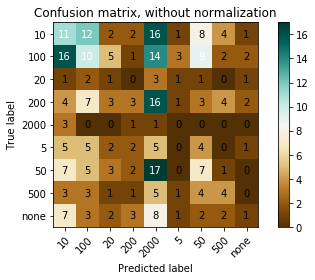

In [0]:
plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000','5', '50', '500', 'none']), False)

Confusion matrix, without normalization
[[11  7 16  0 18  3  1  0  1]
 [25  7  0  1 25  4  0  0  0]
 [ 1  0  0  9  0  0  0  0  0]
 [ 3  2  1  2  0  0 33  0  2]
 [ 0  0  0  0  0  0  0  0  5]
 [ 0 24  0  0  0  0  0  0  0]
 [ 1  4  0  0 36  1  0  0  0]
 [ 1  1  0  0  3  0  0 17  0]
 [15  2  2  3  3  0  4  0  0]]


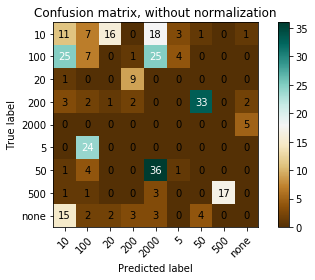

In [0]:
plot_confusion_matrix(test_generator.classes, y_pred, np.array(['10', '100', '20', '200', '2000','5', '50', '500', 'none']), False)

In [0]:
print(classification_report(test_generator.classes[test_generator.index_array], y_pred))

              precision    recall  f1-score   support

           0       0.19      0.19      0.19        57
           1       0.21      0.16      0.18        62
           2       0.05      0.10      0.07        10
           3       0.20      0.07      0.10        43
           4       0.01      0.20      0.02         5
           5       0.00      0.00      0.00        24
           6       0.18      0.17      0.17        42
           7       0.24      0.18      0.21        22
           8       0.12      0.03      0.05        29

    accuracy                           0.13       294
   macro avg       0.13      0.12      0.11       294
weighted avg       0.17      0.13      0.14       294



## Convert to TFLite

In [0]:
saved_model_dir = path_data + '/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(saved_model_dir + '/model-5.tflite', 'wb') as f:
  f.write(tflite_model)

W0904 10:05:10.543230 139901422983040 nn_ops.py:4283] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0904 10:05:29.172558 139901422983040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1782: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
saved_model_dir

'/content/drive/My Drive/fastai-v3/Indian-Currency-Dataset/train/save/fine_tuning'

In [0]:
from google.colab import files

files.download(saved_model_dir + '/model-5.tflite')
# files.download('labels.txt')

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()